# 01 Getting Started

Welcome to liionpack the battery pack simulation tool built using the PyBaMM battery mathematical modelling framework. This notebook will help you getting started.

First lets start off by importing the package as well as some other useful ones

In [1]:
try:
    import liionpack as lp
except:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np

We can create a pack definition in one of two ways: using an existing netlist or by specifying the number of batteries to connect in series and parallel.

Let's use the second option as it is the simplest using default parameters for resistances to define a 4p1s pack

In [2]:
I_mag = 5.0
OCV_init = 4.0  # used for intial guess
Ri_init = 5e-2  # used for intial guess
R_busbar = 1.5e-3
R_connection = 1e-2
Np = 4
Ns = 1
Nbatt = Np * Ns
netlist = lp.setup_circuit(
    Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init, I=I_mag
)

[The returned object is a pandas Dataframe containing description of the circuit elememt, the nodes in the circuit that they connect between and the initial value. For elements beginning with R the value is in [$\Omega$], for the batteries the open circuit voltage and an internal resistor are included and the value is in [V] and for the current source the value is in [A].

In [3]:
print(netlist)

    desc  node1  node2    value  node1_x  node1_y  node2_x  node2_y
0   Rbn0      1      2  0.00150        0        0        1        0
1   Rbn1      2      3  0.00150        1        0        2        0
2   Rbn2      3      4  0.00150        2        0        3        0
3    Rc0      5      1  0.01000        0        1        0        0
4     V0      9      5  4.00000        0        2        0        1
5    Ri0     13      9  0.05000        0        3        0        2
6    Rc1      6      2  0.01000        1        1        1        0
7     V1     10      6  4.00000        1        2        1        1
8    Ri1     14     10  0.05000        1        3        1        2
9    Rc2      7      3  0.01000        2        1        2        0
10    V2     11      7  4.00000        2        2        2        1
11   Ri2     15     11  0.05000        2        3        2        2
12   Rc3      8      4  0.01000        3        1        3        0
13    V3     12      8  4.00000        3        

This is the simplest pack we can have which is just one battery connected in series with two busbars and some extra resistors representing the connections to busbars and the internal resistance

We can view the circuit with a helper function

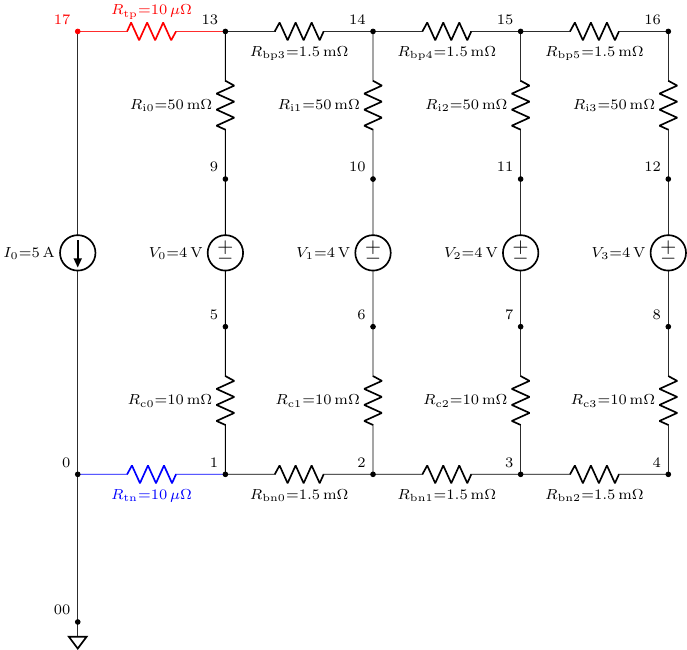

In [4]:
lp.draw_circuit(netlist, cpt_size=1.0, dpi=150, node_spacing=2.5)

Now lets generate an experimental protocol to use for the pack simulation. This will be the applied terminal current for each time step.

In [5]:
experiment = pybamm.Experiment(
    [
        "Charge at 5 A for 30 minutes",
        "Rest for 15 minutes",
        "Discharge at 5 A for 30 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

Now we need to define the battery to be used in the simulation. This is done by using the PyBaMM ParameterValues class which is contructed using a parameter_set. We will use our favourite one which is the Chen2020 parameter set collected for the LG M50 21700 5 Ah cell.

In [6]:
parameter_values = pybamm.ParameterValues("Chen2020")

By default the simulation will output an array containing data for each time step and each battery. The default data that is included is the 'Cell current [A]', 'Terminal voltage [V]', and 'Measured battery open circuit voltage [V]'. However, we can also include additional variables to output from the models. The full list can be found associated with the SPMe model in PyBaMM.

In [7]:
SPMe = pybamm.models.full_battery_models.lithium_ion.SPMe()

Here we just print the first 10

In [8]:
SPMe.variable_names()[:10]

['Time [s]',
 'Time [min]',
 'Time [h]',
 'x [m]',
 'x_n [m]',
 'x_s [m]',
 'x_p [m]',
 'r_n [m]',
 'r_p [m]',
 'Current variable [A]']

There are many but they can also be searched for

In [9]:
SPMe.variables.search("X-averaged")

Sum of x-averaged negative electrode electrolyte reaction source terms [A.m-3]
Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]
Sum of x-averaged positive electrode electrolyte reaction source terms [A.m-3]
Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]
X-averaged Ohmic heating [W.m-3]
X-averaged SEI concentration [mol.m-3]
X-averaged SEI film overpotential [V]
X-averaged SEI interfacial current density [A.m-2]
X-averaged SEI on cracks concentration [mol.m-3]
X-averaged SEI on cracks interfacial current density [A.m-2]
X-averaged SEI on cracks thickness [m]
X-averaged SEI thickness [m]
X-averaged battery concentration overpotential [V]
X-averaged battery electrolyte ohmic losses [V]
X-averaged battery open circuit voltage [V]
X-averaged battery reaction overpotential [V]
X-averaged battery solid phase ohmic losses [V]
X-averaged cell temperature [C]
X-averaged cell temperature [K]
X-averaged concentration overp

Lets pick a few more interesting ones to output

In [10]:
output_variables = [
    "X-averaged negative particle surface concentration [mol.m-3]",
    "X-averaged positive particle surface concentration [mol.m-3]",
]

N.B that only 0D variables can be output from the simulation i.e. the x-averaged or volume-averaged or battery variables

Ok now we're all set we can solve the pack problem

In [11]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
    initial_soc=0.5
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 541/541 [00:06<00:00, 77.46it/s]


Finally we can plot the simulation output

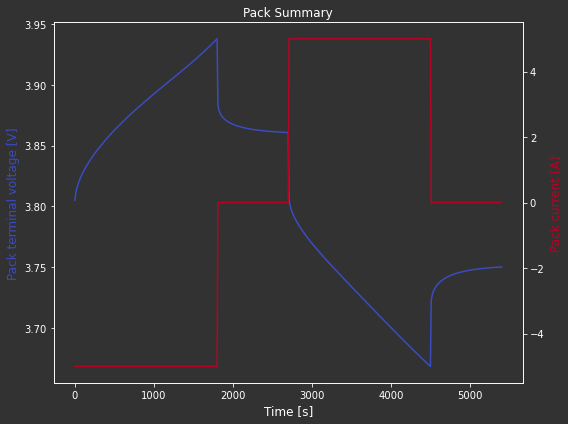

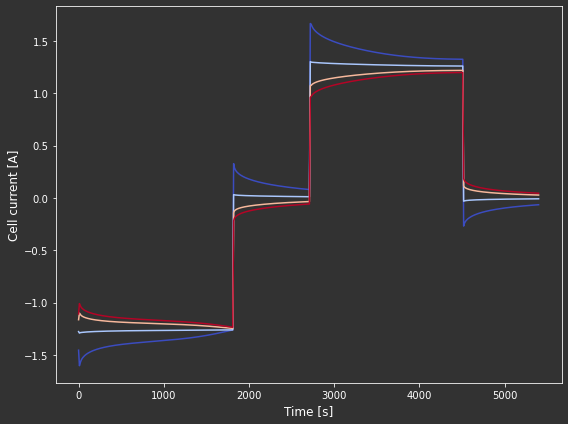

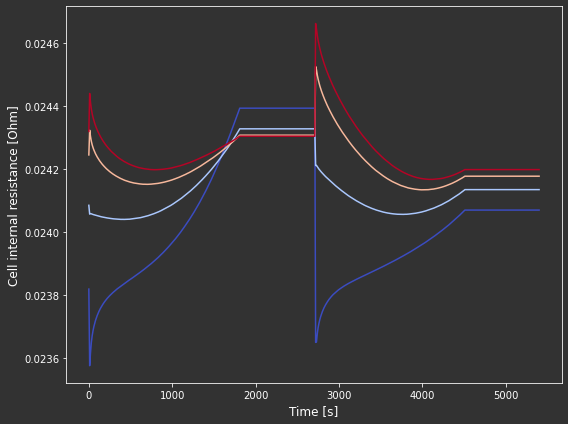

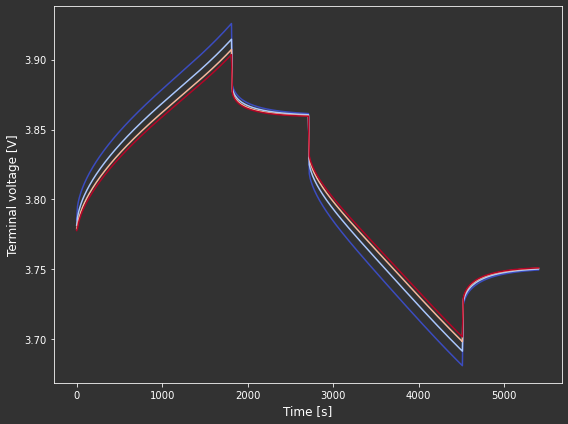

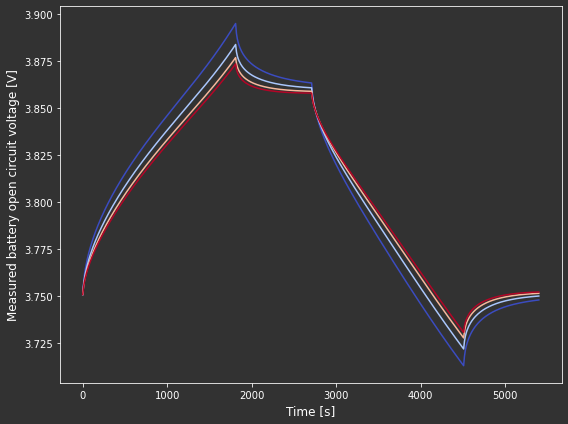

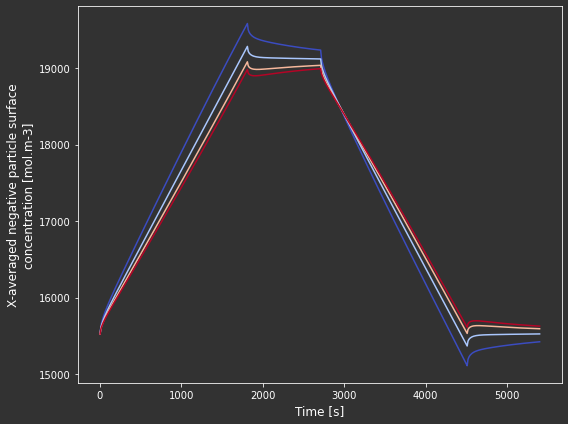

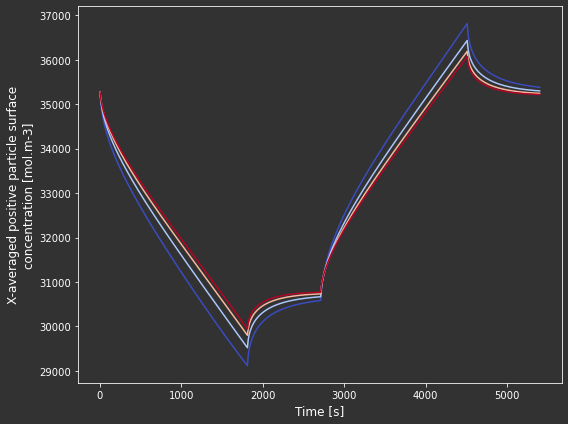

In [12]:
lp.plot_output(output)